### Trend Search Methods

이번 절에서는 $h$나 profit taking, 또는 stopping loss barrier를 정의할 필요가 없는 새로운 labeling 방법을 도입한다. 일반적인 아이디어는 추세를 파악해 barrier를 세우지 않고 지속할 수 있는 한 오래, 그리고 멀리 가도록 하는 것이다. 이를 달성하기 위해서는 먼저 무엇이 추세를 구성하는지 정의해야 한다.

일련의 관측치 $\{x_{t}\}_{t = 1, \dots, T}$, 여기서 $x_t$는 우리가 예측하고자 하는 증권의 가격을 나타낸다. $x_t$가 하강  추세, 보합 또는 상승 추세의 일부인지 여부에 따라서 $x_t$의 모든 관측값에 $y_t \in \{-1, 0, 1\}$ label을 할당하고자 한다. 한 가지 가능한 방법은 선형 시간 추세 모델에서 추정된 회귀 계수 $\hat{t_{\hat{\beta}_1}}$와 관련된 t-value를 계산하는 것이다.

$$x_{t+l} = \beta_0 + \beta_1 l + \epsilon_{t+l}$$
$$\hat{t_{\hat{\beta_1}}} = \frac{\hat{\beta_1}}{\hat{\sigma_{\hat{\beta}_1}}}$$

여기서 $\hat{\sigma_{\hat{\beta}_1}}$는 $\hat{\beta_1}$의 표준 오차로서 $l=0, \dots, L-1$, $L$은 예측 기간을 설정한다. 아래 코드는 $L$에 의해 결정된 샘플에서 이 t-value를 계산한다

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from FinancialMachineLearning.labeling.trend_search import trend_labeling, linear_trend_t_values

In [2]:
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-04-27'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [3]:
t_vals = linear_trend_t_values(close = data['Adj Close'])

In [4]:
print(f't_vals = {t_vals}')

t_vals = 106.87336702881286


$L$의 값이 다르면 t-value가 달라진다. 이 비결정성을 해결하고자 $L$에 대해 여러 값 집합을 시도해 보고, $|\hat{t_{\beta_1}}|$을 최대화하는 $L$의 값을 선택할 수 있다. 이러한 방식으로, 여러 가능한 미래 전망 기간 중 미래에 관측되는 가장 통계적으로 유의한 추세에 따라서 $x_t$ labeling을 한다. 

아래의 코드는 이러한 절차를 구현한 코드이다. 인수로는 labeling하기 원하는 관측값의 지수인 molecule, $\{x_t\}$의 time series 종가, 알고리즘이 최대 절대 $t$값을 찾고자 평가할 $L$의 값 집합인 span이다. 출력은 index가 $x_t$의 timestamp인 data frame이고, column `t1`은 가장 유의한 추세를 찾는 데 사용되는 가장 먼 관측값의 timestamp를 나타내며, column `tVal`은 평가된 전망 기간 집합 중 가장 유의한 선형 추세와 연관된 t-value를 나타내며, column `bin`은 label($y_t$)이다

In [5]:
trend_search = trend_labeling(
    data.index, # datetime Index
    data['Adj Close'], # price series
    span = [1, 20, 1] # time range(start, end, stepsize)
)

In [6]:
trend_search.head()

,t1,tVal,bin
Date,,,
2000-01-03,2000-01-28,-5.391453,-1.0
2000-01-04,2000-01-31,-3.914067,-1.0
2000-01-05,2000-02-01,3.924727,1.0
2000-01-06,2000-02-02,5.065569,1.0
2000-01-07,2000-02-03,-6.635165,-1.0


Trending Searching label은 많은 경우 직관적이며, 회귀 문제뿐만 아니라 분류에도 사용될 수 있다. 아래 일련의 결과는 Trend Searching Methods를 사용해 labeling을 하는 법을 보여준다

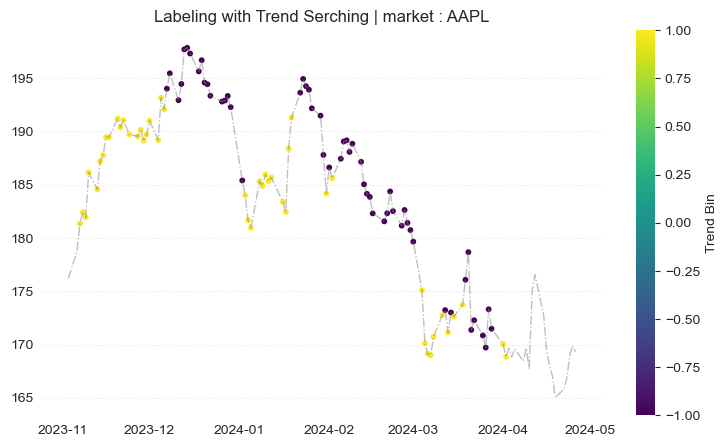

In [7]:
fig, ax = plt.subplots(figsize = (9, 5))
scatter = ax.scatter(
    trend_search.index[-100:], 
    data['Adj Close'].loc[trend_search.index].values[-100:], 
    c = trend_search['bin'].values[-100:], 
    cmap = 'viridis',
    s = 10
)
ax.plot(
    data['Adj Close'][-120:], 
    color = 'gray', 
    alpha = 0.5,
    ls = '-.',
    lw = 1
)

for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Labeling with Trend Serching | market : AAPL')

cbar = fig.colorbar(scatter)
cbar.set_label('Trend Bin')
cbar.outline.set_visible(False)

plt.show()

bin값을 추정하는데 사용된 t value는 machine learning 알고리즘 내에서 sample weight로도 사용이 가능하다. 자세한 내용은 chapter 4에서 다루도록 한다

In [8]:
scale = trend_search['tVal'].copy()

scale[scale > 10] = 10
scale[scale < -10] = -10

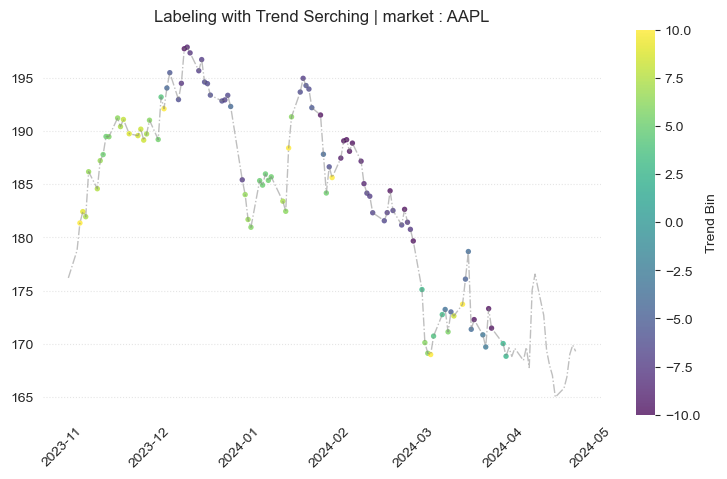

In [9]:
fig, ax = plt.subplots(figsize = (9, 5))
scatter = ax.scatter(
    trend_search.index[-100:], 
    data['Adj Close'].loc[trend_search.index].values[-100:], 
    c = scale[-100:], 
    cmap = 'viridis',
    alpha = 0.75,
    edgecolor = 'none',
    s = 15
)
ax.plot(
    data['Adj Close'][-120:], 
    color = 'gray', 
    alpha = 0.5,
    ls = '-.',
    lw = 1
)
plt.xticks(rotation=45)
for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Labeling with Trend Serching | market : AAPL')

cbar = fig.colorbar(scatter)
cbar.set_label('Trend Bin')
cbar.outline.set_visible(False)

plt.show()